In [1]:
import pathlib; from pathlib import Path; import pandas as pd
import os ; import pathlib as pl ; from pprint import pformat ; import flopy ; import git ; import matplotlib.pyplot as plt
import numpy as np ; from flopy.plot.styles import styles  ;from modflow_devtools.misc import get_env, timed 
from flopy.utils.postprocessing import get_water_table ; import flopy.utils.binaryfile as bf
write = get_env("WRITE", True) ; run = get_env("RUN", True) ;  plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True) ; plot_save = get_env("PLOT_SAVE", True)

In [2]:
example_name = "ex-gwt-mt3dms-p03"
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\98_Plus\02_MT3D


In [3]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\98_Plus\\02_MT3D')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'B_p03_V01c'    ; workspace = os.path.join('.', directory_name)
if os.path.isdir(workspace) is False:
    os.mkdir(workspace) 
output_folder = Path('B_p03_V01c') ; output_folder.mkdir(exist_ok=True)

In [4]:
# parameters and variables 
length_units = "meters"
time_units = "days"
nlay = 1  # Number of layers
nrow = 31  # Number of rows
ncol = 46  # Number of columns
delr = 10.0  # Column width ($m$)
delc = 10.0  # Row width ($m$)
delz = 10.0  # Layer thickness ($m$)
top = 0.0  # Top of the model ($m$)
prsity = 0.3  # Porosity
perlen = 365  # Simulation time ($days$)
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
qwell = 1.0  # Volumetric injection rate ($m^3/d$)
cwell = 1000.0  # Concentration of injected water ($mg/L$)
al = 10.0  # Longitudinal dispersivity ($m$)
trpt = 0.3  # Ratio of transverse to longitudinal dispersivity
perlen = [1, 365.0]
nper = len(perlen)
nstp = [2, 730]
tsmult = [1.0, 1.0]
sconc = 0.0
dt0 = 0.3
ath1 = al * trpt
dmcoef = 0.0
botm = [top - delz]  # Model geometry
k33 = k11  # Vertical hydraulic conductivity ($m/d$)
icelltype = 0
Lx = (ncol - 1) * delr
v = 1.0 / 3.0
prsity = 0.3
q = v * prsity
h1 = q * Lx
strt = np.zeros((nlay, nrow, ncol), dtype=float)
strt[0, :, 0] = h1

nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
percel = 1.0    # HMOC parameters in case they are invoked
itrack = 3      # HMOC
wd = 0.5        # HMOC

dceps = 1.0e-5  # HMOC
nplane = 1      # HMOC
npl = 0         # HMOC
nph = 16        # HMOC
npmin = 4       # HMOC
npmax = 32       # HMOC
dchmoc = 1.0e-3  # HMOC
nlsink = nplane  # HMOC
npsink = nph     # HMOC

tdis_rc = []

In [5]:
idomain = np.ones((nlay, nrow, ncol), dtype=int)
c0 = 0.0
cncspd = [[(0, 0, 0), c0]]
spd_mf6 = {0: [[(0, 15, 15), qwell, cwell]]}  # MF6 pumping information
chdspd = []        ; rowList = np.arange(0, nrow).tolist()
for itm in rowList :
    chdspd.append  ([(0, itm, 0), h1])
    chdspd.append  ([(0, itm, ncol - 1), 0.0])
chdspd = {0: chdspd}                                        # ; chdspd

In [6]:
# MOFLOW | MT3DMS
def build_models(sim_name, mixelm=0, silent=False):
    name = "p03-mf6"
    gwfname = "gwf-" + name
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    tdis_rc = ((1, 365, 1.0),(750, 750, 1.0))
    flopy.mf6.ModflowTdis        (sim, nper=nper, perioddata=tdis_rc, time_units=time_units)
    
    gwf = flopy.mf6.ModflowGwf   (sim,modelname=gwfname,save_flows=True,model_nam_file=f"{gwfname}.nam")
    imsgwf = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                                  inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose,linear_acceleration="CG",
                                  scaling_method="NONE",reordering_method="NONE",relaxation_factor=relax,filename=f"{gwfname}.ims")
    sim.register_ims_package (imsgwf, [gwf.name])
    
    flopy.mf6.ModflowGwfdis  (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,
                              idomain=np.ones((nlay, nrow, ncol), dtype=int),filename=f"{gwfname}.dis")
    
    flopy.mf6.ModflowGwfnpf  (gwf,save_flows=False,icelltype=icelltype,k=k11,k33=k33,save_specific_discharge=True,filename=f"{gwfname}.npf")
    flopy.mf6.ModflowGwfic   (gwf, strt=strt, filename=f"{gwfname}.ic")
    sto = flopy.mf6.ModflowGwfsto (gwf, ss=0, sy=0, filename=f"{gwfname}.sto")   ; rowList = np.arange(0, nrow).tolist()  ; chdspd = []
    for itm in rowList:
        chdspd.append([(0, itm, 0), h1])
        chdspd.append([(0, itm, ncol - 1), 0.0])
    chdspd = {0: chdspd}
    flopy.mf6.ModflowGwfchd  (gwf,maxbound=len(chdspd),stress_period_data=chdspd,save_flows=False,pname="CHD-1",filename=f"{gwfname}.chd")
    flopy.mf6.ModflowGwfwel  (gwf,print_input=True,print_flows=True,stress_period_data=spd_mf6,save_flows=False,
                              auxiliary="CONCENTRATION",pname="WEL-1",filename=f"{gwfname}.wel")
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=f"{gwfname}.hds",budget_filerecord=f"{gwfname}.bud",
                              headprintrecord=[("COLUMNS", 31, "WIDTH", 15, "DIGITS", 2, "GENERAL")],
                              saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
                              printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")])                            
    
    gwtname = "gwt_" + name
    gwt    = flopy.mf6.MFModel   (sim,model_type="gwt6",modelname=gwtname,model_nam_file=f"{gwtname}.nam")   
    gwt.name_file.save_flows = True
    
    imsgwt = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                                  inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose,
                                  linear_acceleration="BICGSTAB",scaling_method="NONE",reordering_method="NONE",
                                  relaxation_factor=relax,filename=f"{gwtname}.ims")                  
    sim.register_ims_package  (imsgwt, [gwt.name])
    
    flopy.mf6.ModflowGwtdis   (gwt,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=1,filename=f"{gwtname}.dis")
    
    flopy.mf6.ModflowGwtic    (gwt, strt=sconc, filename=f"{gwtname}.ic")
    if mixelm == 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv     (gwt, scheme=scheme, filename=f"{gwtname}.adv")
    if al != 0:
        flopy.mf6.ModflowGwtdsp (gwt,xt3d_off=True,alh=al,ath1=ath1,filename=f"{gwtname}.dsp",)
    flopy.mf6.ModflowGwtmst     (gwt,porosity=prsity,first_order_decay=False,decay=None,decay_sorbed=None,sorption=None,
                                 bulk_density=None,distcoef=None,filename=f"{gwtname}.mst")
    flopy.mf6.ModflowGwtcnc     (gwt,maxbound=len(cncspd),stress_period_data=cncspd,save_flows=False,pname="CNC-1",filename=f"{gwtname}.cnc")      
    sourcerecarray = [("WEL-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm     (gwt, sources=sourcerecarray, filename=f"{gwtname}.ssm")
    flopy.mf6.ModflowGwtoc      (gwt,budget_filerecord=f"{gwtname}.cbc",concentration_filerecord=f"{gwtname}.UCN",
                                 concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                                 saverecord=[("CONCENTRATION", "ALL")],
                                 printrecord=[("CONCENTRATION", "ALL"), ])    
    flopy.mf6.ModflowGwfgwt      (sim,exgtype="GWF6-GWT6",exgmnamea=gwfname,exgmnameb=gwtname,filename=f"{name}.gwfgwt")
    return sim

def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent, report=True)    ; assert success, pformat(buff)

In [7]:
def plot_results(mf6, idx, ax=None):
    mf6.simulation_data.mfpath.get_sim_path()
    gwt = mf6.get_model(list(mf6.model_names)[1])  ; ucnobj_mf6 = gwt.output.concentration()  ; conc_mf6=ucnobj_mf6.get_alldata()

    with styles.USGSPlot() as fs:
        sim_name = mf6.name  ;  plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]
        if ax is None:
            fig = plt.figure(figsize=(5, 3), dpi=150, tight_layout=True)  ; ax = fig.add_subplot(1, 1, 1, aspect="equal")
        mm = flopy.plot.PlotMapView(model=gwt)          ; mm.plot_grid(color=".2", alpha=0.1)
        cs2 = mm.contour_array(conc_mf6[1], levels=[0.1, 1.0, 10.0, 20.0], colors="r", linestyles="-")
        plt.clabel(cs2, inline=1, fontsize=10)          ; title = f"Plume at Time = 365 {time_units}"      
        letter = chr(ord("@") + idx + 1)                ; styles.heading(letter=letter, heading=title)
        plt.show()

run_models took 4607.27 ms


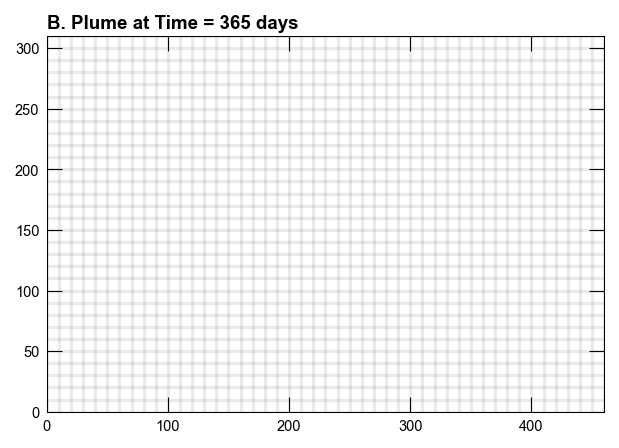

In [8]:
def scenario(idx, silent=True):
    sim = build_models(example_name)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, idx)
scenario(1)

In [9]:
sim_ws = os.path.join (workspace, 'ex-gwt-mt3dms-p03')    
fname = os.path.join(sim_ws, 'gwf-p03-mf6'+'.hds')  ; hdobj = flopy.utils.HeadFile(fname)    ; heads = hdobj.get_data()
times = hdobj.get_times()
times                                 # [1.0, 366.0]

[1.0, 751.0]

In [10]:
sim_ws = os.path.join (workspace, 'ex-gwt-mt3dms-p03') 
fname = os.path.join(sim_ws, 'gwt_p03-mf6.UCN')     ; fname    
# ucnobj = flopy.utils.UcnFile(fname)   # ; times = np.array(ucnobj.get_times())  ; conc = ucnobj.get_alldata() # ??

'.\\B_p03_V01c\\ex-gwt-mt3dms-p03\\gwt_p03-mf6.UCN'